In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# Use the full path to the file found in the input directory
file_path = '/kaggle/input/basketball/csv/game.csv'
data = pd.read_csv(file_path)

# Convert game_date to datetime if it's not already
data['game_date'] = pd.to_datetime(data['game_date'])

# Select the desired columns from the 'data' DataFrame
new_table = data[['team_abbreviation_home', 'game_date','plus_minus_home',
                    'matchup_home', 
                  'team_abbreviation_away', 'plus_minus_away']]

# Display the new table
print(new_table.head(10))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

  team_abbreviation_home  game_date  plus_minus_home matchup_home  \
0                    HUS 1946-11-01               -2  HUS vs. NYK   
1                    BOM 1946-11-02                5  BOM vs. PIT   
2                    PRO 1946-11-02                6  PRO vs. BOS   
3                    CHS 1946-11-02               16  CHS vs. NYK   
4                    DEF 1946-11-02              -17  DEF vs. WAS   
5                    CLR 1946-11-03               11  CLR vs. HUS   
6                    PIT 1946-11-04              -15  PIT vs. WAS   
7                    BOS 1946-11-05               -2  BOS vs. CHS   
8                    DEF 1946-11-05               -4  DEF vs. BOM   
9                    PRO 1946-11-07                8  PRO vs. CHS   

  team_abbreviation_away  plus_minus_away  
0                    NYK                2  
1                    PIT               -5  
2                    BOS               -6  
3                    NYK              -16  
4                   

In [2]:
# Define a function to calculate the season
def calculate_season(date):
    year = date.year
    # If the month is between January (1) and June (6), the season is the previous year to the current year
    if date.month <= 6:
        return f'{year - 1}-{str(year)[-2:]}'
    # If the month is between July (7) and December (12), the season is the current year to the next year
    else:
        return f'{year}-{str(year + 1)[-2:]}'

# Ensure you're working with a copy of the DataFrame when assigning a new column
new_table = new_table.copy()

# Now apply the function to calculate the season safely using .loc
new_table['season'] = new_table['game_date'].apply(calculate_season)

# Filter the data to keep only rows with the season >= '2002-03'
my_data = new_table[new_table['season'] >= '2002-03']

# Display the filtered table
print(my_data.head())


      team_abbreviation_home  game_date  plus_minus_home matchup_home  \
38493                    LAL 2002-10-29               -5  LAL vs. SAS   
38494                    ORL 2002-10-29                7  ORL vs. PHI   
38495                    SAC 2002-10-29               27  SAC vs. CLE   
38496                    DET 2002-10-30                9  DET vs. NYK   
38497                    TOR 2002-10-30                6  TOR vs. WAS   

      team_abbreviation_away  plus_minus_away   season  
38493                    SAS                5  2002-03  
38494                    PHI               -7  2002-03  
38495                    CLE              -27  2002-03  
38496                    NYK               -9  2002-03  
38497                    WAS               -6  2002-03  


In [3]:
import pandas as pd

# Filter for clutch games (games where plus_minus_home or plus_minus_away is between -3 and 3)
clutch_games = my_data[(my_data['plus_minus_home'] >= -3) & (my_data['plus_minus_home'] <= 3) |
                       (my_data['plus_minus_away'] >= -3) & (my_data['plus_minus_away'] <= 3)]

# Function to determine if the home team won or lost (1-3 points)
def clutch_result(row):
    if row['plus_minus_home'] <= -1:
        return 'loss_home'
    elif row['plus_minus_home'] >= 1:
        return 'win_home'
    elif row['plus_minus_away'] <= -1:
        return 'loss_away'
    elif row['plus_minus_away'] >= 1:
        return 'win_away'
    return None  # Exclude other games (non-clutch)

# Apply the function to get the result of the clutch games
clutch_games['result'] = clutch_games.apply(clutch_result, axis=1)

# Filter for wins and losses
wins = clutch_games[clutch_games['result'].isin(['win_home', 'win_away'])]
losses = clutch_games[clutch_games['result'].isin(['loss_home', 'loss_away'])]

# Create a matrix for wins by team abbreviation and year
wins_matrix_home = pd.pivot_table(wins, values='game_date', index=wins['season'], columns=wins['team_abbreviation_home'], aggfunc='count', fill_value=0)
wins_matrix_away = pd.pivot_table(wins, values='game_date', index=wins['season'], columns=wins['team_abbreviation_away'], aggfunc='count', fill_value=0)

# Create a matrix for losses by team abbreviation and year
losses_matrix_home = pd.pivot_table(losses, values='game_date', index=losses['season'], columns=losses['team_abbreviation_home'], aggfunc='count', fill_value=0)
losses_matrix_away = pd.pivot_table(losses, values='game_date', index=losses['season'], columns=losses['team_abbreviation_away'], aggfunc='count', fill_value=0)

# Combine the home and away results for wins and losses
wins_matrix = wins_matrix_home.add(wins_matrix_away, fill_value=0)
losses_matrix = losses_matrix_home.add(losses_matrix_away, fill_value=0)

# Compute the clutch wins minus losses
clutch_diff = wins_matrix - losses_matrix

# Add average for each column at the bottom
wins_matrix.loc['Average'] = wins_matrix.mean()
losses_matrix.loc['Average'] = losses_matrix.mean()
clutch_diff.loc['Average'] = clutch_diff.mean()

# Display all three tables
print("Clutch Wins Matrix:")
print(wins_matrix)

print("\nClutch Losses Matrix:")
print(losses_matrix)

print("\nClutch Wins - Losses Matrix:")
print(clutch_diff)


Clutch Wins Matrix:
              ALB        ATL       BKN        BOS        CHA        CHI  \
season                                                                    
2002-03  0.000000  12.000000  0.000000   6.000000   0.000000  10.000000   
2003-04  0.000000   2.000000  0.000000   8.000000   0.000000   4.000000   
2004-05  0.000000   5.000000  0.000000  11.000000  10.000000   5.000000   
2005-06  0.000000  18.000000  0.000000  15.000000   9.000000   8.000000   
2006-07  0.000000   4.000000  0.000000   7.000000   4.000000  11.000000   
2007-08  0.000000   9.000000  0.000000   8.000000   6.000000   4.000000   
2008-09  0.000000  10.000000  0.000000  11.000000   8.000000  12.000000   
2009-10  0.000000   9.000000  0.000000   7.000000  12.000000  12.000000   
2010-11  0.000000   7.000000  0.000000  12.000000   9.000000   8.000000   
2011-12  0.000000  11.000000  0.000000   8.000000   3.000000   4.000000   
2012-13  0.000000   1.000000  1.000000   0.000000   0.000000   2.000000   
2013-

<ipython-input-3-0db717966733>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clutch_games['result'] = clutch_games.apply(clutch_result, axis=1)


In [4]:
import pandas as pd

# Filter for clutch games (games where plus_minus_home or plus_minus_away is between -3 and 3)
clutch_games = my_data[(my_data['plus_minus_home'] >= -3) & (my_data['plus_minus_home'] <= 3) |
                       (my_data['plus_minus_away'] >= -3) & (my_data['plus_minus_away'] <= 3)]

# Function to determine if the home team won or lost (1-3 points)
def clutch_result(row):
    if row['plus_minus_home'] <= -1:
        return 'loss_home'
    elif row['plus_minus_home'] >= 1:
        return 'win_home'
    elif row['plus_minus_away'] <= -1:
        return 'loss_away'
    elif row['plus_minus_away'] >= 1:
        return 'win_away'
    return None  # Exclude other games (non-clutch)

# Apply the function to get the result of the clutch games
clutch_games['result'] = clutch_games.apply(clutch_result, axis=1)

# Filter for wins and losses
wins = clutch_games[clutch_games['result'].isin(['win_home', 'win_away'])]
losses = clutch_games[clutch_games['result'].isin(['loss_home', 'loss_away'])]

# Create a matrix for wins by team abbreviation and year
wins_matrix_home = pd.pivot_table(wins, values='game_date', index=wins['season'], columns=wins['team_abbreviation_home'], aggfunc='count', fill_value=0)
wins_matrix_away = pd.pivot_table(wins, values='game_date', index=wins['season'], columns=wins['team_abbreviation_away'], aggfunc='count', fill_value=0)

# Create a matrix for losses by team abbreviation and year
losses_matrix_home = pd.pivot_table(losses, values='game_date', index=losses['season'], columns=losses['team_abbreviation_home'], aggfunc='count', fill_value=0)
losses_matrix_away = pd.pivot_table(losses, values='game_date', index=losses['season'], columns=losses['team_abbreviation_away'], aggfunc='count', fill_value=0)

# Combine the home and away results for wins and losses
wins_matrix = wins_matrix_home.add(wins_matrix_away, fill_value=0)
losses_matrix = losses_matrix_home.add(losses_matrix_away, fill_value=0)

# Compute the clutch wins minus losses
clutch_diff = wins_matrix - losses_matrix

# Filter for just "NOH" and "NOP" results
wins_matrix_noh_nop = wins_matrix[['NOH', 'NOP']]
losses_matrix_noh_nop = losses_matrix[['NOH', 'NOP']]
clutch_diff_noh_nop = clutch_diff[['NOH', 'NOP']]

# Add average for each column at the bottom
wins_matrix_noh_nop.loc['Average'] = wins_matrix_noh_nop.mean()
losses_matrix_noh_nop.loc['Average'] = losses_matrix_noh_nop.mean()
clutch_diff_noh_nop.loc['Average'] = clutch_diff_noh_nop.mean()

# Display the results for just "NOH" and "NOP"
print("Clutch Wins Matrix for NOH and NOP:")
print(wins_matrix_noh_nop)

print("\nClutch Losses Matrix for NOH and NOP:")
print(losses_matrix_noh_nop)

print("\nClutch Wins - Losses Matrix for NOH and NOP:")
print(clutch_diff_noh_nop)


Clutch Wins Matrix for NOH and NOP:
               NOH        NOP
season                       
2002-03   5.000000   0.000000
2003-04   6.000000   0.000000
2004-05   9.000000   0.000000
2005-06   0.000000   0.000000
2006-07   0.000000   0.000000
2007-08   7.000000   0.000000
2008-09   7.000000   0.000000
2009-10   5.000000   0.000000
2010-11  13.000000   0.000000
2011-12   5.000000   0.000000
2012-13   0.000000   0.000000
2013-14   0.000000   7.000000
2014-15   0.000000  10.000000
2015-16   0.000000   9.000000
2016-17   0.000000   6.000000
2017-18   0.000000   7.000000
2018-19   0.000000   5.000000
2019-20   0.000000   1.000000
2020-21   0.000000   7.000000
2021-22   0.000000   4.000000
2022-23   0.000000   6.000000
Average   2.714286   2.952381

Clutch Losses Matrix for NOH and NOP:
              NOH        NOP
season                      
2002-03  10.00000   0.000000
2003-04   9.00000   0.000000
2004-05   8.00000   0.000000
2005-06   0.00000   0.000000
2006-07   0.00000   0.000000
20

<ipython-input-4-852aa68cd7c5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clutch_games['result'] = clutch_games.apply(clutch_result, axis=1)
<ipython-input-4-852aa68cd7c5>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wins_matrix_noh_nop.loc['Average'] = wins_matrix_noh_nop.mean()
<ipython-input-4-852aa68cd7c5>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  losses_m

In [5]:
import pandas as pd

# List of allowed team abbreviations (merged SEA/OKC, NOP/NOH)
allowed_teams = [
    'ATL', 'BOS', 'BKN', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL',
    'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS'
]

# Filter the my_data table to keep only the rows with the allowed teams
# Combine "SEA" and "OKC" into "OKC" and "NOP" and "NOH" into "NOP"
my_data_filtered = my_data[my_data['team_abbreviation_home'].isin(allowed_teams) | my_data['team_abbreviation_away'].isin(allowed_teams)]

# Combine SEA and OKC into OKC, and NOP and NOH into NOP
my_data_filtered['team_abbreviation_home'] = my_data_filtered['team_abbreviation_home'].replace({'SEA': 'OKC', 'NOH': 'NOP'})
my_data_filtered['team_abbreviation_away'] = my_data_filtered['team_abbreviation_away'].replace({'SEA': 'OKC', 'NOH': 'NOP'})

# Now we can proceed with your original pivot table code with the filtered data

# Filter for clutch games (games where plus_minus_home or plus_minus_away is between -3 and 3)
clutch_games = my_data_filtered[(my_data_filtered['plus_minus_home'] >= -3) & (my_data_filtered['plus_minus_home'] <= 3) |
                                (my_data_filtered['plus_minus_away'] >= -3) & (my_data_filtered['plus_minus_away'] <= 3)]

# Function to determine if the home team won or lost (1-3 points)
def clutch_result(row):
    if row['plus_minus_home'] <= -1:
        return 'loss_home'
    elif row['plus_minus_home'] >= 1:
        return 'win_home'
    elif row['plus_minus_away'] <= -1:
        return 'loss_away'
    elif row['plus_minus_away'] >= 1:
        return 'win_away'
    return None  # Exclude other games (non-clutch)

# Apply the function to get the result of the clutch games
clutch_games['result'] = clutch_games.apply(clutch_result, axis=1)

# Filter for wins and losses
wins = clutch_games[clutch_games['result'].isin(['win_home', 'win_away'])]
losses = clutch_games[clutch_games['result'].isin(['loss_home', 'loss_away'])]

# Create a matrix for wins by team abbreviation and year
wins_matrix_home = pd.pivot_table(wins, values='game_date', index=wins['season'], columns=wins['team_abbreviation_home'], aggfunc='count', fill_value=0)
wins_matrix_away = pd.pivot_table(wins, values='game_date', index=wins['season'], columns=wins['team_abbreviation_away'], aggfunc='count', fill_value=0)

# Create a matrix for losses by team abbreviation and year
losses_matrix_home = pd.pivot_table(losses, values='game_date', index=losses['season'], columns=losses['team_abbreviation_home'], aggfunc='count', fill_value=0)
losses_matrix_away = pd.pivot_table(losses, values='game_date', index=losses['season'], columns=losses['team_abbreviation_away'], aggfunc='count', fill_value=0)

# Combine the home and away results for wins and losses
wins_matrix = wins_matrix_home.add(wins_matrix_away, fill_value=0)
losses_matrix = losses_matrix_home.add(losses_matrix_away, fill_value=0)

# Compute the clutch wins minus losses
clutch_diff = wins_matrix - losses_matrix

# Filter for just "NOH"/"NOP" and "SEA"/"OKC" results
wins_matrix_filtered = wins_matrix[allowed_teams]
losses_matrix_filtered = losses_matrix[allowed_teams]
clutch_diff_filtered = clutch_diff[allowed_teams]

# Add average for each column at the bottom
wins_matrix_filtered.loc['Average'] = wins_matrix_filtered.mean()
losses_matrix_filtered.loc['Average'] = losses_matrix_filtered.mean()
clutch_diff_filtered.loc['Average'] = clutch_diff_filtered.mean()

# Display the filtered results
print("Clutch Wins Matrix (Filtered):")
print(wins_matrix_filtered)

print("\nClutch Losses Matrix (Filtered):")
print(losses_matrix_filtered)

print("\nClutch Wins - Losses Matrix (Filtered):")
print(clutch_diff_filtered)


<ipython-input-5-4a8584233a00>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data_filtered['team_abbreviation_home'] = my_data_filtered['team_abbreviation_home'].replace({'SEA': 'OKC', 'NOH': 'NOP'})
<ipython-input-5-4a8584233a00>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data_filtered['team_abbreviation_away'] = my_data_filtered['team_abbreviation_away'].replace({'SEA': 'OKC', 'NOH': 'NOP'})
<ipython-input-5-4a8584233a00>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy 

Clutch Wins Matrix (Filtered):
               ATL        BOS       BKN        CHA        CHI        CLE  \
season                                                                     
2002-03  12.000000   6.000000  0.000000   0.000000  10.000000   7.000000   
2003-04   2.000000   8.000000  0.000000   0.000000   4.000000   7.000000   
2004-05   5.000000  11.000000  0.000000  10.000000   5.000000   6.000000   
2005-06  18.000000  15.000000  0.000000   9.000000   8.000000  10.000000   
2006-07   4.000000   7.000000  0.000000   4.000000  11.000000  13.000000   
2007-08   9.000000   8.000000  0.000000   6.000000   4.000000   8.000000   
2008-09  10.000000  11.000000  0.000000   8.000000  12.000000   5.000000   
2009-10   9.000000   7.000000  0.000000  12.000000  12.000000  10.000000   
2010-11   7.000000  12.000000  0.000000   9.000000   8.000000   4.000000   
2011-12  11.000000   8.000000  0.000000   3.000000   4.000000   5.000000   
2012-13   1.000000   0.000000  1.000000   0.000000   2.00

<ipython-input-5-4a8584233a00>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wins_matrix_filtered.loc['Average'] = wins_matrix_filtered.mean()
<ipython-input-5-4a8584233a00>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  losses_matrix_filtered.loc['Average'] = losses_matrix_filtered.mean()
<ipython-input-5-4a8584233a00>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clutch_diff_filtered.loc['Average'] = clutch_diff_filtered.m

In [6]:
import pandas as pd

# List of allowed team abbreviations (merged SEA/OKC, NOP/NOH)
allowed_teams = [
    'ATL', 'BOS', 'BKN', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL',
    'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS'
]

# Filter the my_data table to keep only the rows with the allowed teams
# Combine "SEA" and "OKC" into "OKC" and "NOP" and "NOH" into "NOP"
my_data_filtered = my_data[my_data['team_abbreviation_home'].isin(allowed_teams) | my_data['team_abbreviation_away'].isin(allowed_teams)]

# Combine SEA and OKC into OKC, and NOP and NOH into NOP
my_data_filtered['team_abbreviation_home'] = my_data_filtered['team_abbreviation_home'].replace({'SEA': 'OKC', 'NOH': 'NOP'})
my_data_filtered['team_abbreviation_away'] = my_data_filtered['team_abbreviation_away'].replace({'SEA': 'OKC', 'NOH': 'NOP'})

# Now we can proceed with your original pivot table code with the filtered data

# Filter for clutch games (games where plus_minus_home or plus_minus_away is between -3 and 3)
clutch_games = my_data_filtered[(my_data_filtered['plus_minus_home'] >= -3) & (my_data_filtered['plus_minus_home'] <= 3) |
                                (my_data_filtered['plus_minus_away'] >= -3) & (my_data_filtered['plus_minus_away'] <= 3)]

# Function to determine if the home team won or lost (1-3 points)
def clutch_result(row):
    if row['plus_minus_home'] <= -1:
        return 'loss_home'
    elif row['plus_minus_home'] >= 1:
        return 'win_home'
    elif row['plus_minus_away'] <= -1:
        return 'loss_away'
    elif row['plus_minus_away'] >= 1:
        return 'win_away'
    return None  # Exclude other games (non-clutch)

# Apply the function to get the result of the clutch games
clutch_games['result'] = clutch_games.apply(clutch_result, axis=1)

# Filter for wins and losses
wins = clutch_games[clutch_games['result'].isin(['win_home', 'win_away'])]
losses = clutch_games[clutch_games['result'].isin(['loss_home', 'loss_away'])]

# Create a matrix for wins by team abbreviation and year
wins_matrix_home = pd.pivot_table(wins, values='game_date', index=wins['season'], columns=wins['team_abbreviation_home'], aggfunc='count', fill_value=0)
wins_matrix_away = pd.pivot_table(wins, values='game_date', index=wins['season'], columns=wins['team_abbreviation_away'], aggfunc='count', fill_value=0)

# Create a matrix for losses by team abbreviation and year
losses_matrix_home = pd.pivot_table(losses, values='game_date', index=losses['season'], columns=losses['team_abbreviation_home'], aggfunc='count', fill_value=0)
losses_matrix_away = pd.pivot_table(losses, values='game_date', index=losses['season'], columns=losses['team_abbreviation_away'], aggfunc='count', fill_value=0)

# Combine the home and away results for wins and losses
wins_matrix = wins_matrix_home.add(wins_matrix_away, fill_value=0)
losses_matrix = losses_matrix_home.add(losses_matrix_away, fill_value=0)

# Compute the clutch wins minus losses
clutch_diff = wins_matrix - losses_matrix

# Filter for just "NOH"/"NOP" and "SEA"/"OKC" results
wins_matrix_filtered = wins_matrix[allowed_teams]
losses_matrix_filtered = losses_matrix[allowed_teams]
clutch_diff_filtered = clutch_diff[allowed_teams]

# Add average for each column at the bottom
wins_matrix_filtered.loc['Average'] = wins_matrix_filtered.mean()
losses_matrix_filtered.loc['Average'] = losses_matrix_filtered.mean()
clutch_diff_filtered.loc['Average'] = clutch_diff_filtered.mean()

# Sort the clutch difference matrix from high to low
clutch_diff_filtered_sorted = clutch_diff_filtered.sort_values(by='Average', axis=1, ascending=False)

# Display the filtered and sorted results
print("Clutch Wins Matrix (Filtered):")
print(wins_matrix_filtered)

print("\nClutch Losses Matrix (Filtered):")
print(losses_matrix_filtered)

print("\nClutch Wins - Losses Matrix (Filtered and Sorted):")
print(clutch_diff_filtered_sorted)


Clutch Wins Matrix (Filtered):
               ATL        BOS       BKN        CHA        CHI        CLE  \
season                                                                     
2002-03  12.000000   6.000000  0.000000   0.000000  10.000000   7.000000   
2003-04   2.000000   8.000000  0.000000   0.000000   4.000000   7.000000   
2004-05   5.000000  11.000000  0.000000  10.000000   5.000000   6.000000   
2005-06  18.000000  15.000000  0.000000   9.000000   8.000000  10.000000   
2006-07   4.000000   7.000000  0.000000   4.000000  11.000000  13.000000   
2007-08   9.000000   8.000000  0.000000   6.000000   4.000000   8.000000   
2008-09  10.000000  11.000000  0.000000   8.000000  12.000000   5.000000   
2009-10   9.000000   7.000000  0.000000  12.000000  12.000000  10.000000   
2010-11   7.000000  12.000000  0.000000   9.000000   8.000000   4.000000   
2011-12  11.000000   8.000000  0.000000   3.000000   4.000000   5.000000   
2012-13   1.000000   0.000000  1.000000   0.000000   2.00

<ipython-input-6-3dfe9d2880f9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data_filtered['team_abbreviation_home'] = my_data_filtered['team_abbreviation_home'].replace({'SEA': 'OKC', 'NOH': 'NOP'})
<ipython-input-6-3dfe9d2880f9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data_filtered['team_abbreviation_away'] = my_data_filtered['team_abbreviation_away'].replace({'SEA': 'OKC', 'NOH': 'NOP'})
<ipython-input-6-3dfe9d2880f9>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy 

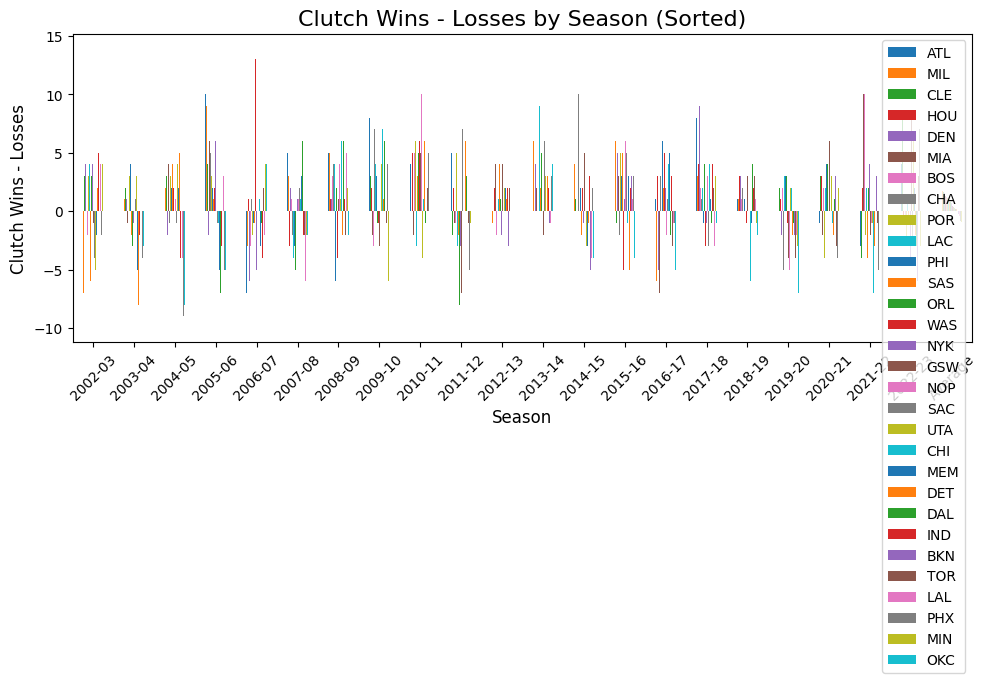

In [7]:
import matplotlib.pyplot as plt

# Assuming clutch_diff_filtered_sorted is already calculated and available

# Plot the data
clutch_diff_filtered_sorted.plot(kind='bar', figsize=(10, 6))

# Set plot title and labels
plt.title('Clutch Wins - Losses by Season (Sorted)', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Clutch Wins - Losses', fontsize=12)

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


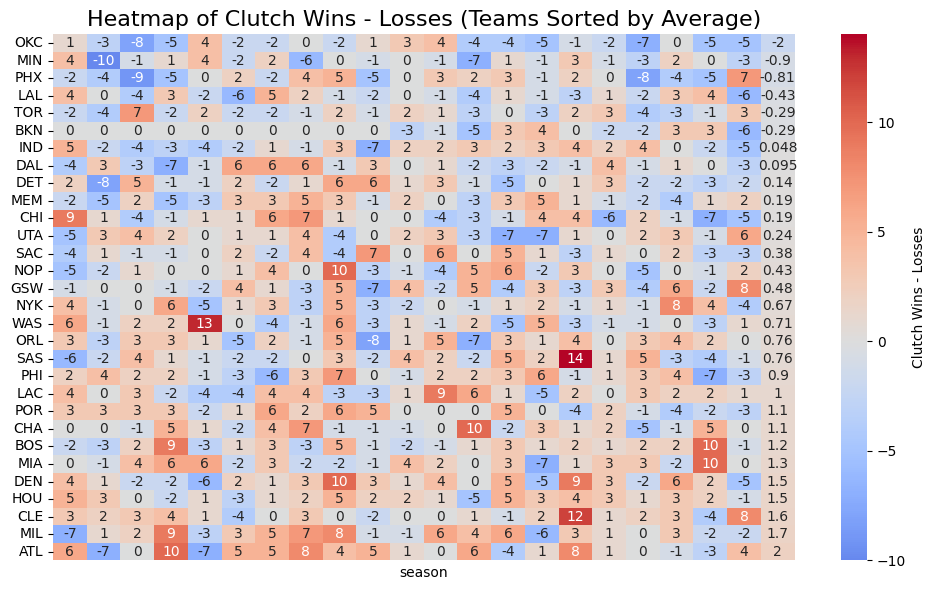

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the average clutch wins minus losses for each team
average_clutch_diff = clutch_diff_filtered_sorted.mean(axis=0)

# Sort the teams by their average clutch difference (from lowest to highest)
average_clutch_diff_sorted = average_clutch_diff.sort_values()

# Reorder the data based on the sorted team averages
clutch_diff_sorted_teams = clutch_diff_filtered_sorted[average_clutch_diff_sorted.index]

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(clutch_diff_sorted_teams.T, annot=True, cmap="coolwarm", center=0, cbar_kws={'label': 'Clutch Wins - Losses'}, xticklabels=False)

# Set plot title
plt.title('Heatmap of Clutch Wins - Losses (Teams Sorted by Average)', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()


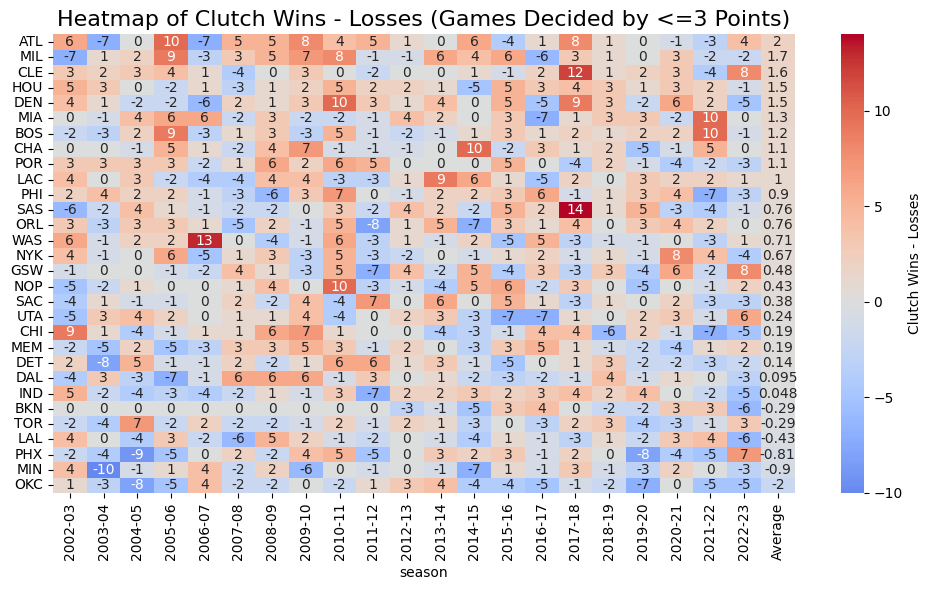

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the average clutch wins minus losses for each team
average_clutch_diff = clutch_diff_filtered_sorted.mean(axis=0)

# Sort the teams by their average clutch difference (from highest to lowest)
average_clutch_diff_sorted = average_clutch_diff.sort_values(ascending=False)

# Round the averages to 1 decimal place
average_clutch_diff_sorted = average_clutch_diff_sorted.round(1)

# Reorder the data based on the sorted team averages
clutch_diff_sorted_teams = clutch_diff_filtered_sorted[average_clutch_diff_sorted.index]

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(clutch_diff_sorted_teams.T, annot=True, cmap="coolwarm", center=0, cbar_kws={'label': 'Clutch Wins - Losses'}, xticklabels=True)

# Set plot title
plt.title('Heatmap of Clutch Wins - Losses (Games Decided by <=3 Points)', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()
